## Numeric Optimization of cost functions of 1 parameter

In [2]:
# do the usual imports
import numpy as np
import scipy.signal
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt

In [3]:
def hill_descent_1D( fn, p0 ):
    ''' Find the parameter that minimizes the function fn
    where fn is a function of just one parameter.
    p0 is the initial guess for the parameter.
    The approach taken to find the minimal value of fn is 
    a hill-descending approach.
    Returns the best parameter value and its cost (as a tuple)'''
    # The current value of the parameter
    currP = p0
    # How much we will adjust the parameter by to take a setp
    delP = 0.05*p0
    # how much we will adjust the size of our next parameter step
    accel = 1.2
    # how close the costs need to be before we stop taking steps.
    tol = 1e-4
    # candidate step sizes (small and big, negative and positive)
    candidates = np.array([-accel,-1/accel,1/accel,accel])
    while True:
        currCost = fn(currP) # evaluate the cost at the current parameter value
        # then evaluate at 2 steps to the "left" and 2 steps to the "right"
        costs = np.array(list(map(fn,currP+candidates*delP)))
        # find the minium cost and the index of which step took us too it
        mCost = costs.min()
        mIdx = np.argmin(costs)
        if currCost < mCost:
            # no step made the cost any smaller. we should take a smaller step and try again
            delP = delP/accel
        else:
            # update the parameter to the best step taken
            currP = currP + candidates[mIdx]*delP
            # and adjust the step size
            delP = delP*candidates[mIdx]
        if np.abs(currCost-mCost) < tol:
            # if the last step and this step have costs within the tolerance,
            # then it is time to stop looping.
            return (currP, mCost)

best t=3.041324494170096, best f=0.0017077138184142878
The function was evaluated 70 times


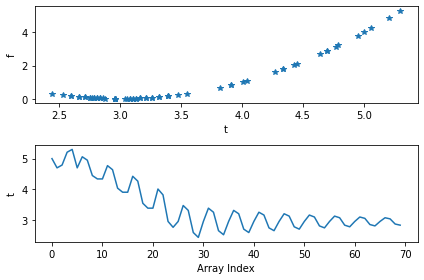

In [26]:
# hill-climbing on quadratic function.
# This quadratic function has been harnessed to debug
# It is passed a parameter for each of the dependent (vals_c) and independent variables (vals_t)
# If those parameters are lists, then add the values of the current indep var (t)
# and the dep var (the result of the function).
# We use this to track the function calls.
# If vals_t and vals_c are None, then we ignore them.
def ftest( t, vals_t = None, vals_c = None ):
    if vals_t is not None:
        vals_t.append( t)
    if vals_c is not None:
        vals_c.append( (t-3)**2 )
    return (t-3)**2

vals_t = []
vals_c = []
f = lambda t: ftest(t, vals_t, vals_c)
(bt,bc) = hill_descent_1D( f, 5 )
print( f"best t={bt}, best f={bc}")
print( f"The function was evaluated {len(vals_t)} times")
    
#print(vals_t, vals_c)    
plt.subplot( 2, 1, 1)
plt.plot( vals_t, vals_c, '*');
plt.xlabel( 't')
plt.ylabel( 'f')
plt.subplot( 2, 1, 2 )
plt.plot( vals_t );
plt.xlabel( 'Array Index')
plt.ylabel( 't');
plt.tight_layout();

best t=3.009724730540047, best f=0.009746910915615192
The function was evaluated 110 times


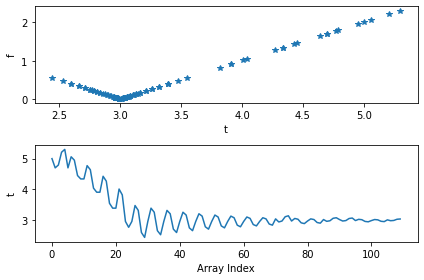

In [27]:
# Does the hill climbing algorithm work for abs value function?
# result: sort of. it does take more steps, presumably because the values don't flatten out at the bottom.
def ftest2( t, vals_t = None, vals_c = None ):
    if vals_t is not None:
        vals_t.append( t)
    if vals_c is not None:
        vals_c.append( np.abs(t-3) )
    return np.abs(t-3)
vals_t = []
vals_c = []
f = lambda t: ftest2(t, vals_t, vals_c)
(bt,bc) = hill_descent_1D( f, 5 )
print( f"best t={bt}, best f={bc}")
print( f"The function was evaluated {len(vals_t)} times")
    
#print(vals_t, vals_c)    
plt.subplot( 2, 1, 1)
plt.plot( vals_t, vals_c, '*');
plt.xlabel( 't')
plt.ylabel( 'f')
plt.subplot( 2, 1, 2 )
plt.plot( vals_t );
plt.xlabel( 'Array Index')
plt.ylabel( 't');
plt.tight_layout()

## Van der Pol Oscillator

Define the model function for the van der Pol oscillator. It is defines as

\begin{align*}
\frac{dy_1}{dt} &= y_2\\
\frac{dy_2}{dt} &= \mu (1-y_1^2)y_2 - y_1.\\
\end{align*}

We will assume the unit of time is $h$.

In [17]:
def vdp( t, y, mu ):
    y1 = y[0]
    y2 = y[1]
    dydt = np.zeros((2,))
    dydt[0] = y2
    dydt[1] = mu*(1-y1**2)*y2 - y1
    return dydt

### Run the model

Use $\mu$=0.1. Run it for 500 h at a tight tolerance. Then run it again for 100 h and plot the result.

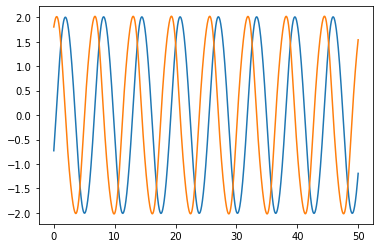

In [19]:
mu = .1;
mf = lambda t,y : vdp(t,y,mu)
sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,200), y0=(.1,.1), rtol=1e-8, atol=1e-8 )
sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,50), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,50,.01) )
plt.plot( sol2.t, sol2.y.T );

### define get_period
Stephanie copied her code from HW2.

In [34]:
def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        if the value of the standard deviation is not smaller than 0.1, then
        it means the period estimate is dodgy and you shouldn't use it. Instead,
        plot your simulation and figure out why it isn't periodic - maybe it just
        hasn't reached the limit cycle yet."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

### Replot the van der Pol oscillation with the period

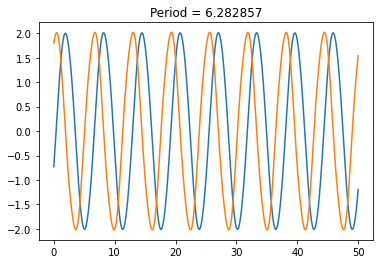

In [20]:
plt.plot( sol2.t, sol2.y.T );
(period,sdperiod) = get_period( sol2.t, sol2.y[0,:])
plt.title( 'Period = %f' % period );

### Define the van der Pol error function

It should take the parameter $\mu$ as input and return the squared difference between the simulated period and 10 h. 

To find the simulated period, first run the model for 200 hours and ignore the result. The simulate for another 50 h and call get_period.

In [28]:
# this is the van-dep tpol function augmented for debugging - we can
# add to vals_t and vals_c if they are lists (which is what we assume they 
# are if they are not None).
def vdp_error( mu, vals_t = None, vals_c = None ):
    mf = lambda t,y : vdp(t,y,mu)
    sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,200), y0=(.1,.1) )
    sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,50), y0=sol1.y[:,-1], t_eval=np.arange(0,50,.01) )
    (period,period_sd) = get_period( sol2.t, sol2.y[0,:] )
    if vals_t is not None:
        vals_t.append( mu )
    if vals_c is not None:
        vals_c.append( (period-10)**2 )
    return (period-10)**2
    

### Plot the cost function landscape

Plot the cost over 100 values of $\mu$ ranging from 0.01 to 5.

Then plot the result from the Hill descent method beginning at $\mu=0.2$.

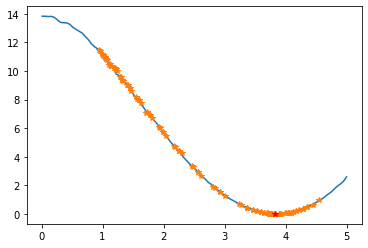

In [29]:
mus = np.linspace( 0.01, 5, 100 )
errors = np.zeros( mus.shape )
for i in range(mus.size):
    errors[i] = vdp_error( mus[i] )

plt.plot( mus, errors );

vals_t = []
vals_c = []
f = lambda t: vdp_error(t, vals_t, vals_c)

# starting from 0.2 gets stuck
(mu,cost) = hill_descent_1D( f, p0=1 )
plt.plot( vals_t, vals_c,'*')
plt.plot( mu, cost, 'r*')

In [225]:
print( len(vals_t))

110


Do built-in local methods do any better? Not really.

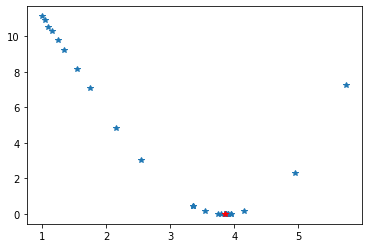

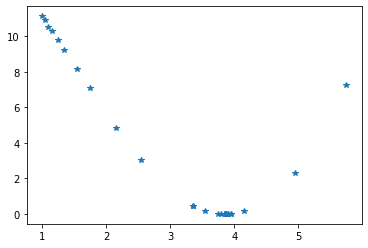

In [30]:
# mus = np.linspace( 0.01, 5, 100 )
# errors = np.zeros( mus.shape )
# for i in range(mus.size):
#     errors[i] = vdp_error( mus[i] )

# plt.plot( mus, errors );

mu_vals = []
cost_vals = []
fn = lambda mu:vdp_error( mu, mu_vals, cost_vals )
# try with x0=0.1 and x0=1 and Nelder-Mead (a simplex method)
# Powell from 0.2 works well (a gradient method)
# SLSQP from 0.2 took so long I made tea.
res = scipy.optimize.minimize( fn, method='Nelder-Mead', x0=1 )
plt.plot( mu_vals, cost_vals,'*')
plt.plot( res.x, vdp_error(res.x), 'r*')

plt.figure()
plt.plot(mu_vals, cost_vals,'*');

In [222]:
print(len(mu_vals))

51


### What if we have multiple parameters?

Let's code up the Goodwin Oscillator

In [205]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

def goodwin_circadian_error( params ):
    mf = lambda t,y : goodwin_oscillator(t,y, params)

    sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,500), y0=(.1,.1,.1) )
    sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                    t_eval=np.arange(0,100,.01) )
    (period,sdper) = get_period( sol2.t, sol2.y[0,:] )
    return (period-24)**2


3.156544444444447


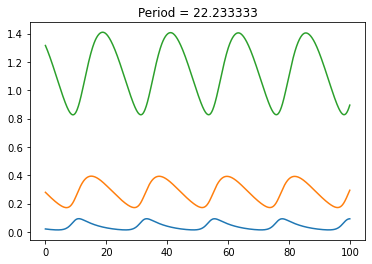

In [212]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

params = (alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3)

mf = lambda t,y : goodwin_oscillator(t,y, params)

sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,200), y0=(.1,.1,.1), 
                                t_eval=np.arange(0,200,.1) )
sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,100,.1) )

plt.plot( sol2.t, sol2.y.T )
(period,sdperiod) = get_period( sol2.t, sol2.y[0,:])
plt.title( 'Period = %f' % period );

err = goodwin_circadian_error( params )
print( err )

In [209]:
# Run a built-in optimizer and print the results
res = scipy.optimize.minimize( goodwin_circadian_error, method='Nelder-Mead', x0=params )
print(res)

 final_simplex: (array([[ 1.0441589 ,  0.61506829, 11.60855387,  0.14786071,  0.98794809,
         0.1496552 ,  1.01877043,  0.22496593],
       [ 1.04415183,  0.61506785, 11.60852354,  0.14786095,  0.98796358,
         0.14965528,  1.01877013,  0.22496526],
       [ 1.04415252,  0.61506776, 11.60852725,  0.14786094,  0.98796316,
         0.14965523,  1.01877009,  0.22496521],
       [ 1.04414654,  0.61506735, 11.60849929,  0.14786122,  0.98797646,
         0.14965529,  1.01876942,  0.22496456],
       [ 1.04415606,  0.61506797, 11.60853764,  0.14786084,  0.98795485,
         0.14965522,  1.01877037,  0.22496558],
       [ 1.04415979,  0.61506824, 11.60855888,  0.14786063,  0.98794604,
         0.14965523,  1.01877073,  0.22496615],
       [ 1.04415343,  0.61506782, 11.60852881,  0.1478609 ,  0.98796064,
         0.14965524,  1.01877017,  0.22496535],
       [ 1.04415803,  0.61506797, 11.60855085,  0.14786073,  0.98794976,
         0.14965522,  1.01877068,  0.22496587],
       [ 1.0441

0.0


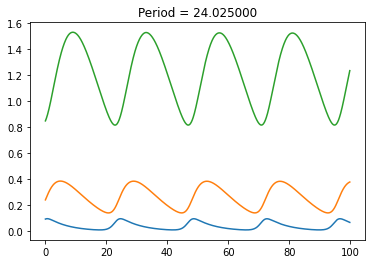

In [214]:
# Use the results from the optimization to run the model
print( goodwin_circadian_error( res.x ))

mf = lambda t,y : goodwin_oscillator(t,y, res.x)

sol1 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,200), y0=(.1,.1,.1), 
                                t_eval=np.arange(0,200,.1) )
sol2 = scipy.integrate.solve_ivp( fun=mf, t_span=(0,100), y0=sol1.y[:,-1], 
                                t_eval=np.arange(0,100,.1) )

plt.plot( sol2.t, sol2.y.T )
(period,sdperiod) = get_period( sol2.t, sol2.y[0,:])
plt.title( 'Period = %f' % period );

